In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('all-data.csv')

In [4]:
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

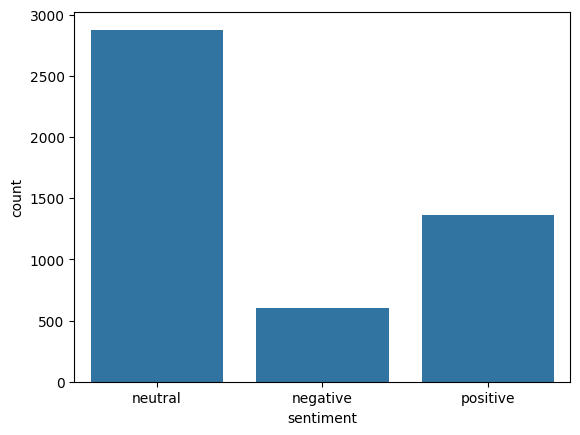

In [6]:
sns.countplot(x='sentiment', data=df)

**Pré-Processamento**

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

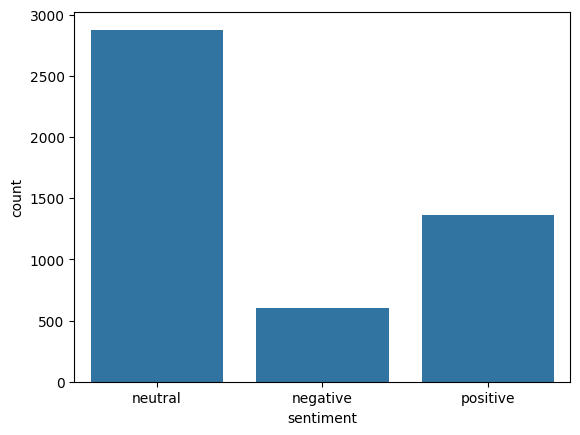

In [11]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

In [12]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sentiment'])

In [13]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [14]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [16]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [18]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 346ms/step - accuracy: 0.5850 - loss: 0.9450 - val_accuracy: 0.6211 - val_loss: 0.8730
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 490ms/step - accuracy: 0.6618 - loss: 0.7891 - val_accuracy: 0.6366 - val_loss: 0.7951
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 416ms/step - accuracy: 0.7486 - loss: 0.6181 - val_accuracy: 0.6753 - val_loss: 0.7689
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 38s 343ms/step - accuracy: 0.8681 - loss: 0.3780 - val_accuracy: 0.6907 - val_loss: 0.7735
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - accuracy: 0.9049 - loss: 0.2779 - val_accuracy: 0.6933 - val_loss: 0.7927
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - accuracy: 0.9450 - loss: 0.1898 - val_accuracy: 0.6856 - val_loss: 1.0583
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9483 - loss: 0.1667 - val_accuracy: 0.6907 - val_loss: 1.2144
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - accuracy: 0.9634 - loss: 0.1293 - val

**UNDERSAMPLING**

In [19]:
from imblearn.under_sampling import RandomUnderSampler

# Inicializar o RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # random_state para reprodutibilidade

# Aplicar o undersampling aos dados de treino
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_pad, y_train)

In [20]:
# Treinar o modelo com os dados balanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10


c:\Users\CADASTRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - accuracy: 0.9180 - loss: 0.2709 - val_accuracy: 0.9060 - val_loss: 0.2965
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.9489 - loss: 0.1694 - val_accuracy: 0.8523 - val_loss: 0.4235
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.9694 - loss: 0.1200 - val_accuracy: 0.8859 - val_loss: 0.3243
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9676 - loss: 0.1034 - val_accuracy: 0.8926 - val_loss: 0.3122
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 399ms/step - accuracy: 0.9851 - loss: 0.0621 - val_accuracy: 0.8859 - val_loss: 0.3391
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 0.9829 - loss: 0.0650 - val_accuracy: 0.8255 - val_loss: 0.5547
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.9887 - loss: 0.0423 - val_accuracy: 0.9060 - val_loss: 0.2742
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.9813 - loss: 0.0588 - val_accuracy: 0.8926

<Axes: xlabel='label_encoded', ylabel='count'>

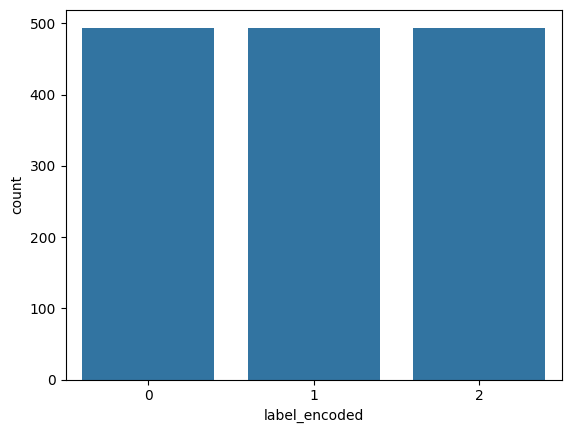

In [21]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step
              precision    recall  f1-score   support

           0       0.45      0.70      0.54       110
           1       0.80      0.75      0.78       571
           2       0.65      0.59      0.62       289

    accuracy                           0.70       970
   macro avg       0.63      0.68      0.65       970
weighted avg       0.72      0.70      0.70       970



In [23]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.6990
Precisão: 0.7179
Recall: 0.6990
F1-Score: 0.7043


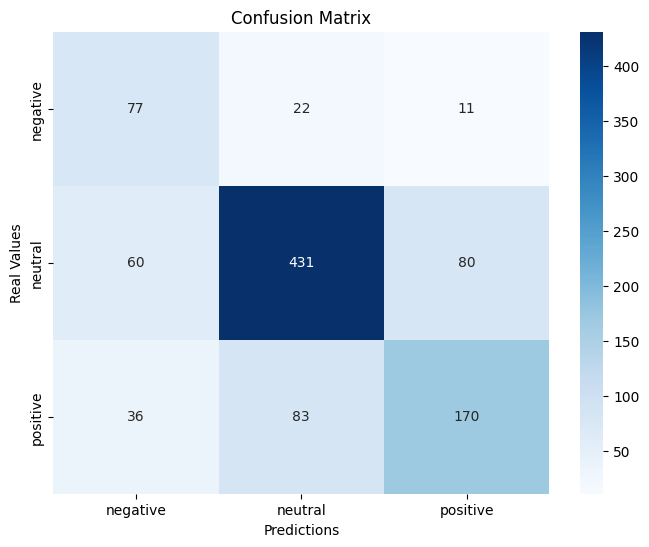

In [24]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [25]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Classe real: neutral
Classe predita: neutral
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step
[(np.str_('square'), -8.35242419928819e-05), (np.str_('meter'), 7.02080259310478e-05), (np.str_('park'), 3.428270348385274e-05), (np.str_('preliminary'), -2.5368558260789825e-05), (np.str_('estimation'), 1.668309030000485e-05), (np.str_('measure'), 1.201351571846665e-05), (np.str_('technology'), -1.8115154404615479e-06)]


In [26]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
square: -0.0001
meter: 0.0001
park: 0.0000
preliminary: -0.0000
estimation: 0.0000
measure: 0.0000
technology: -0.0000


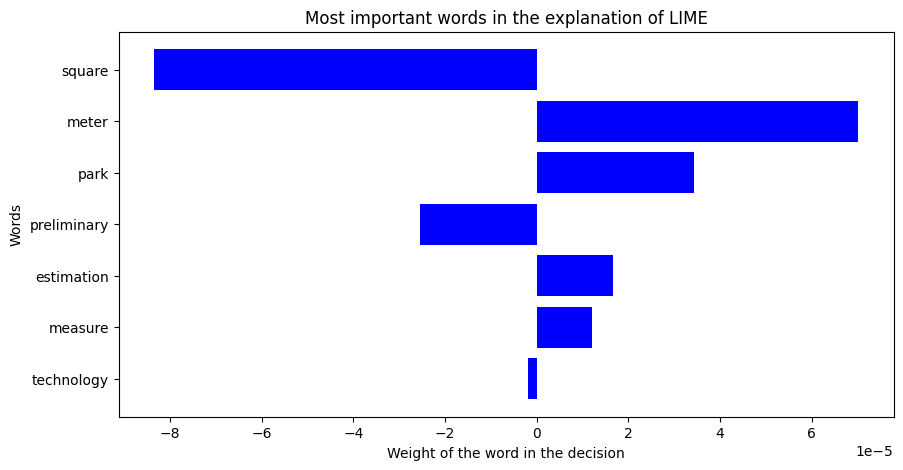

In [27]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [28]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

square: -8.35242419928819e-05
meter: 7.02080259310478e-05
park: 3.428270348385274e-05
preliminary: -2.5368558260789825e-05
estimation: 1.668309030000485e-05
measure: 1.201351571846665e-05
technology: -1.8115154404615479e-06


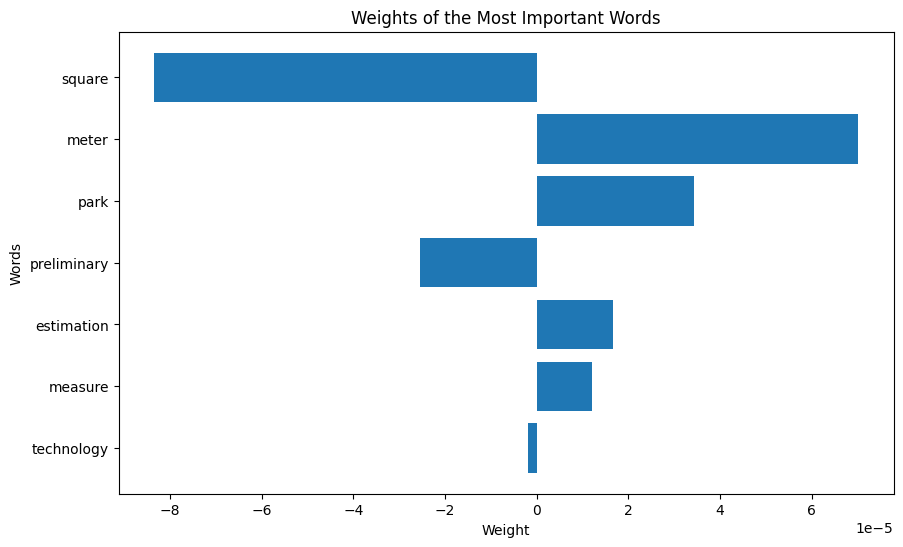

In [29]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [37]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
A classe prevista para o texto é o índice: 1

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
          Feature    Weight
3583   estimation  0.174151
260       measure  0.134672
40     technology  0.103130
595        square  0.066305
1600        meter -0.062692
1383  preliminary -0.162197
477          park -0.163785


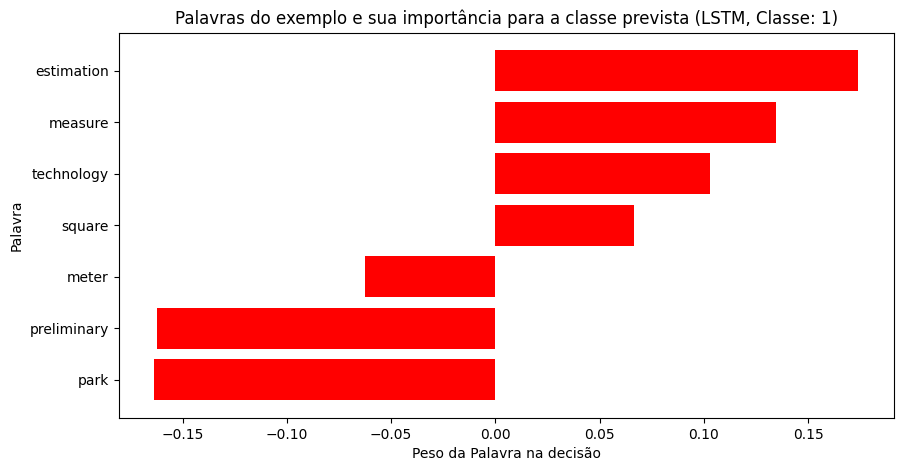

In [ ]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [42]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Weight', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
         Feature    Weight
619       impact  0.833874
646        small  0.755650
2841     suspect  0.701457
106        third  0.660470
882      diluted  0.628495
893   additional  0.592618
695          gas  0.589922
1062       radio  0.589671
1196    informed  0.586804
35         today  0.575874
1341   framework  0.565883
1545     combine  0.554231
572   government  0.542474
1094     publish  0.539595
1941        room  0.536197
3034  mformation  0.532440
3528      cancer  0.531584
1953      answer  0.522132
4300    pharmacy  0.521903
530        crane  0.508494


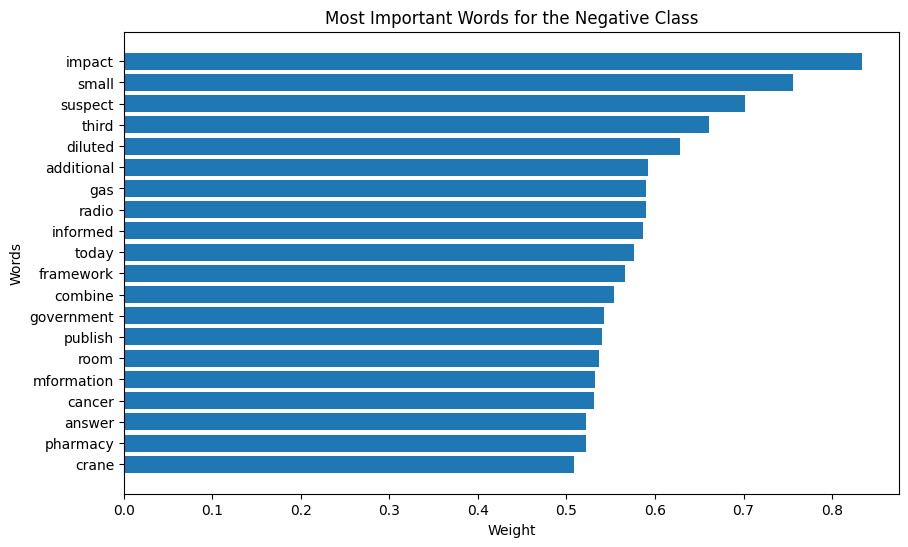

In [43]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [44]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Weight', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
             Feature    Weight
144      transaction  0.523198
106            third  0.505252
54         agreement  0.501235
1407      individual  0.469194
646            small  0.465426
1147            heat  0.449732
1454         romania  0.409600
52           project  0.406577
1094         publish  0.395298
3920  organisational  0.394144
1710           cloud  0.392907
287             real  0.392550
748          science  0.385933
1953          answer  0.373115
547            glass  0.371586
467        marimekko  0.370858
2621         connect  0.370792
421      teliasonera  0.370130
4277      fluctuated  0.365378
3610             gps  0.362346


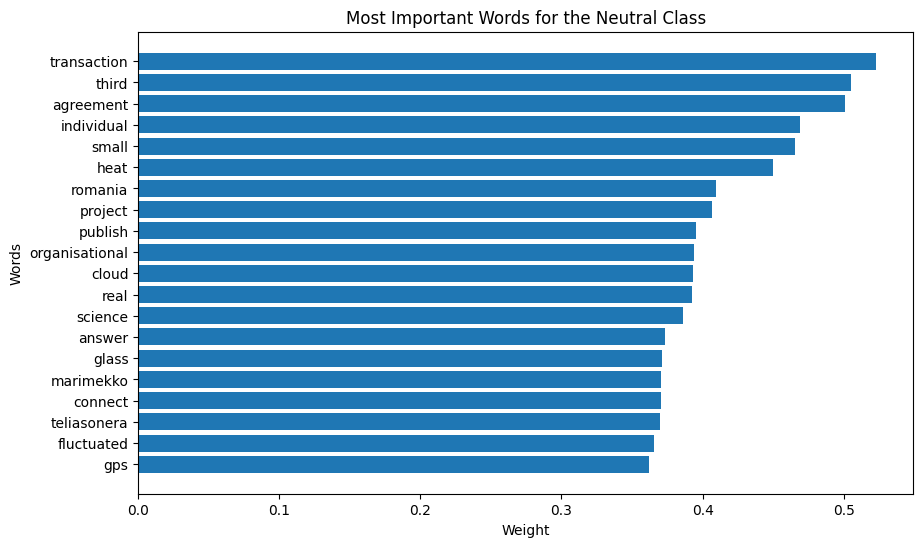

In [45]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [46]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Weight', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
          Feature    Weight
148           say  1.183366
275       leading  1.118154
211          term  0.973222
498          name  0.971208
986        return  0.960743
0           <OOV>  0.951078
3439  circulating  0.942856
851       benefon  0.931019
480        effect  0.929410
564     component  0.925491
197     structure  0.923961
3393          avc  0.917077
3298         prof  0.909137
1386       valued  0.889620
1693     swedbank  0.888765
123       billion  0.883400
575          call  0.870438
587     continued  0.862017
1079         free  0.840707
911       interim  0.840124


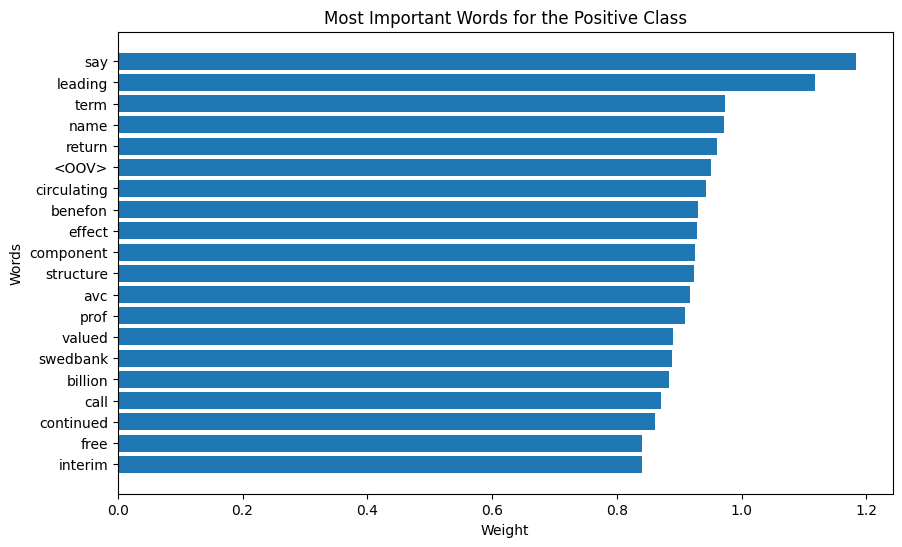

In [47]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()